## Machine learning modeling - Iteration #2

In [199]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [224]:
# read in 990 data that has been
# with features already adjusted in first iteration
df = pd.read_csv('data/990_model_data_2.csv')

In [225]:
df.shape

(26881, 28)

## 2nd Feature Iteration - Remove Outliers


## Remove 1% highest outliers


In [226]:
# select columns to trim
list(df.loc[0,'gross_receipts':].index)

['gross_receipts',
 'voting_memb_ct',
 'voting_indepmemb_ct',
 'employee_tot_ct',
 'volunteer_tot_ct',
 'income_tot_unrelated',
 'income_net_unrelated',
 'rev_less_expense_prioryr',
 'asset_tot_beginyr',
 'liability_tot_beginyr',
 'asset_net_beginyr',
 'rev_less_expense_curyr',
 'asset_tot_endyr',
 'liability_tot_endyr',
 'asset_net_endyr',
 'contractor_100k_ct',
 'CON_CT_DIV_EMP_VOL_CT',
 'CON_EXP_DIV_TOT_EXP',
 'CON_CT_DIV_EMP_VOL_CT_flag',
 'CON_EXP_DIV_TOT_EXP_flag',
 'TARGET_FEATURE',
 'rev_PCA',
 'exp_PCA']

In [227]:
# trim outliers of numeric 
# columns using clip
for c in list(df.loc[0,'gross_receipts':].index):
    df[c].clip(upper=df[c].quantile(0.99), inplace=True)

In [158]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792.0,11,11,37,0.0,0.0,0.0,0.0,39372255.0,26541056.0,12831199.0,0.0,39367859.0,26785093.0,12582766.0,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036.0,9,8,81,8.0,52565.0,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299.0,188534687.0,170915216.0,17619471.0,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978.0,21,19,53,200.0,16110.0,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972.0,3640881.0,852359.0,2788522.0,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298.0,8,7,442,15.0,0.0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630.0,56726534.0,12198910.0,44527624.0,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176.0,12,12,139,50.0,2437.0,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724.0,10535130.0,3089889.0,7445241.0,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [229]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [230]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [231]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.89659662, 0.89231914, 0.89508929, 0.89639137, 0.89748837])

In [232]:
# test model on unseen data
rfc.fit(X_train, y_train)

predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0013950892857142857
Percent Type II errors: 0.09365699404761904

Test set accuracy:
Percent Type I errors: 0.004649432769202157
Percent Type II errors: 0.09243072345173889


In [233]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19114,30
Actual: Yes,2014,346


In [234]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4803,25
Actual: Yes,497,52


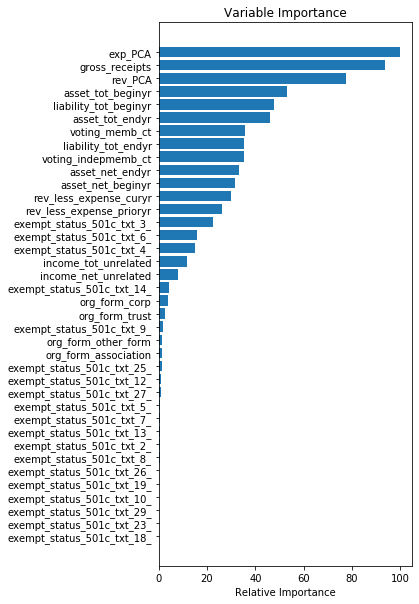

In [235]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

<a id="knn"></a>

## KNN Classifier

In [237]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [238]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [239]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0028366815476190475
Percent Type II errors: 0.1052827380952381

Test set accuracy:
Percent Type I errors: 0.0022317277292170355
Percent Type II errors: 0.09819602008554956


In [240]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19083,61
Actual: Yes,2264,96


In [241]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4816,12
Actual: Yes,528,21


### Gradient Boost Classifier

In [242]:
# Initialize and fit the model.
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
cross_val_score(clf, X, y, cv=5)

array([0.89287707, 0.88971545, 0.88988095, 0.89434524, 0.89581395])

In [243]:
# test model on unseen data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0035807291666666665
Percent Type II errors: 0.0841703869047619

Test set accuracy:
Percent Type I errors: 0.013204389064534127
Percent Type II errors: 0.08517760833178352


In [244]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19067,77
Actual: Yes,1810,550


In [245]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4757,71
Actual: Yes,458,91


Compared with first iteration, type I errors decreased, but type II errors increased

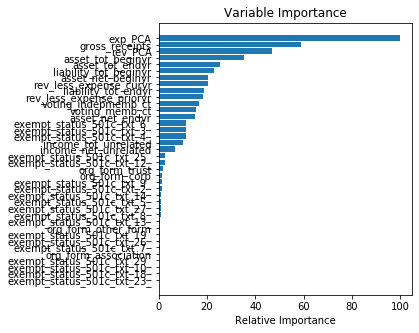

In [246]:
# visualize feature importances
plt.figure(figsize=(10, 7))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

In [247]:
df.to_csv('data/990_model_data_3.csv', index=None, header=True)

# Remove 10% highest outliers


In [270]:
# read in 990 data that has been
# with features already adjusted in first iteration
df = pd.read_csv('data/990_model_data_2.csv')

In [271]:
# select columns to trim
list(df.loc[0,'gross_receipts':].index)

['gross_receipts',
 'voting_memb_ct',
 'voting_indepmemb_ct',
 'employee_tot_ct',
 'volunteer_tot_ct',
 'income_tot_unrelated',
 'income_net_unrelated',
 'rev_less_expense_prioryr',
 'asset_tot_beginyr',
 'liability_tot_beginyr',
 'asset_net_beginyr',
 'rev_less_expense_curyr',
 'asset_tot_endyr',
 'liability_tot_endyr',
 'asset_net_endyr',
 'contractor_100k_ct',
 'CON_CT_DIV_EMP_VOL_CT',
 'CON_EXP_DIV_TOT_EXP',
 'CON_CT_DIV_EMP_VOL_CT_flag',
 'CON_EXP_DIV_TOT_EXP_flag',
 'TARGET_FEATURE',
 'rev_PCA',
 'exp_PCA']

In [272]:
# trim outliers of numeric 
# columns using clip
for c in list(df.loc[0,'gross_receipts':].index):
    df[c].clip(upper=df[c].quantile(0.90), inplace=True)

In [273]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792,11,11,37,0.0,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036,9,8,81,8.0,52565,-75519.0,1000243.0,173898488.0,88052685.0,16354368.0,1262299,188534687,90509772,17619471,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978,21,19,53,200.0,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298,8,7,442,15.0,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176,12,12,139,50.0,2437,0.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


In [274]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [275]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [276]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.89529477, 0.89324902, 0.89601935, 0.89508929, 0.89730233])

In [277]:
# test model on unseen data
rfc.fit(X_train, y_train)

predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0012555803571428572
Percent Type II errors: 0.09528459821428571

Test set accuracy:
Percent Type I errors: 0.004463455458434071
Percent Type II errors: 0.09391854193788358


In [278]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19117,27
Actual: Yes,2049,311


In [279]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4804,24
Actual: Yes,505,44


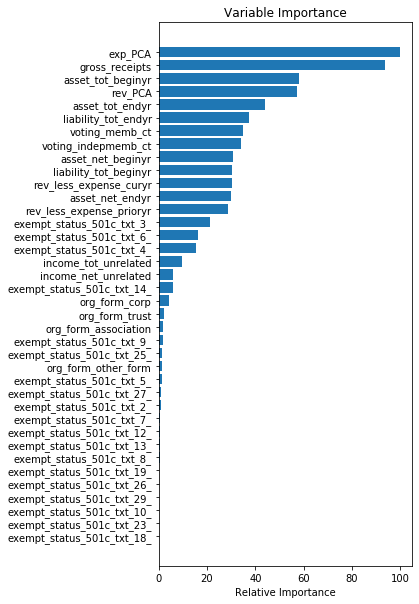

In [280]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

<a id="knn"></a>

## KNN Classifier

In [281]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [282]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0023251488095238095
Percent Type II errors: 0.10560825892857142

Test set accuracy:
Percent Type I errors: 0.001859773107680863
Percent Type II errors: 0.09838199739631764


In [283]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19094,50
Actual: Yes,2271,89


In [284]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4818,10
Actual: Yes,529,20


### Gradient Boost Classifier

In [285]:
# Initialize and fit the model.
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
cross_val_score(clf, X, y, cv=5)

array([0.89194718, 0.89138925, 0.88709077, 0.89285714, 0.89227907])

In [286]:
# test model on unseen data
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.003115699404761905
Percent Type II errors: 0.08621651785714286

Test set accuracy:
Percent Type I errors: 0.01301841175376604
Percent Type II errors: 0.08666542681792822


In [287]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19077,67
Actual: Yes,1854,506


In [288]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4758,70
Actual: Yes,466,83


Compared with first iteration, type I errors decreased, but type II errors increased

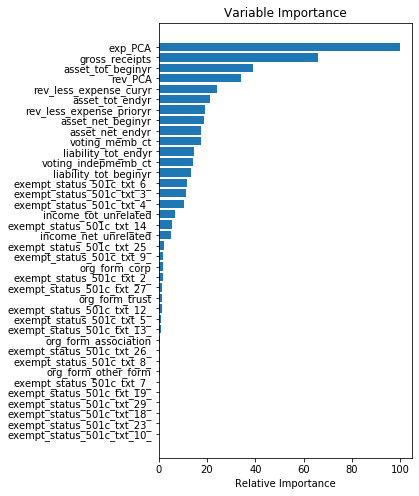

In [289]:
# visualize feature importances
plt.figure(figsize=(10, 8))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

### Export data for further feature iteration

In [290]:
# df.to_csv('data/990_model_data_3.csv', index=None, header=True)